# RL and Advanced DL: Домашнее задание 1

Anna Beketova, ML-32

## About Blackjack

Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.
    
### Description

Card Values:

    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.
    
   This game is played with an infinite deck (or with replacement). The game starts with the dealer having one face up and one face down card, while the player has two face up cards.

The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    
    
### Action Space

There are two actions: stick (0), and hit (1).

### Observation Space
   The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).

### Rewards

* win game: +1
* lose game: -1
* draw game: 0
* win game with natural blackjack:
   
   +1.5 (if 'natural' is True)
   
   +1 (if 'natural' is False)
   
Source: https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

In [1]:
import sys
import gym
from collections import defaultdict
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Some usefull functions

In [2]:
def epsilon_greedy(Q, state, eps):
    if np.random.random() > eps:
        return np.argmax(Q[state])
    else:
        return env.action_space.sample()
    

def estimate_reward(Q, num_episodes=100000):
    reward = 0.
    
    for i in range(num_episodes):
        reward += generate_episode_from_Q(env, Q, 0, env.action_space.n)[-1][-1]
    
    return reward/num_episodes


def get_probs(Q_s, epsilon, n_actions):
    policy_s = np.ones(n_actions) * epsilon / n_actions
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / n_actions)
    return policy_s


def policy_from_Q(Q):
    return dict((k,np.argmax(v)) for k, v in Q.items())


def generate_episode_from_Q(env, Q, epsilon, n_actions):
    episode = []
    state, _ = env.reset()
    terminated = False
    
    while True:
        action = np.random.choice(np.arange(n_actions), p=get_probs(Q[state], epsilon, n_actions)) \
            if state in Q else env.action_space.sample()
        next_state, reward, terminated, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if terminated:
            break
            
    return episode


def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('bone'), vmin=0, vmax=2, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1,2], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)', '2 (DOUBLE)'])
            
    fig = plt.figure(figsize=(15, 15))
    
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

### Little demo on Blackjack environment

In [4]:
env = gym.make('Blackjack-v1', natural=True)

state, _ = env.reset()
print(state, '\n')
print(f"Player's hand: {state[0]}")
print(f"Dealer's one card: {state[1]}")
print(f"If player has usable ace: {state[2]}\n")

action = 1 # hit - draw one more card
print("Action: hit\n")

next_state, reward, terminated, info, _ = env.step(action)
print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"If the game is terminated: {terminated}\n")

action = 0 # stick - stop
print("Action: stick\n")

next_state, reward, terminated, _, _ = env.step(action)
print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"If the game is terminated: {terminated}")

(8, 10, False) 

Player's hand: 8
Dealer's one card: 10
If player has usable ace: False

Action: hit

Next state: (13, 10, False)
Reward: 0.0
If the game is terminated: False

Action: stick

Next state: (13, 10, False)
Reward: -1.0
If the game is terminated: True


In [3]:
N_verbose_batch_size = 1000
N_iterations = 100000

## Часть первая, с блекджеком и стратегиями


## Задания

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Simple strategy: 'stick' action (value 0) if player has 19, 20, 21 in hand, 'hit' action (value 1) - otherwise.

In [5]:
def action_by_simple_strategy(player_hand_value):
    return int(player_hand_value < 19)

def generate_episode_simple_strategy(env):
    episode = []
    state, _ = env.reset()
    
    while True:
        players_hand = state[0]
        action = action_by_simple_strategy(players_hand)
        next_state, reward, terminated, _, _ = env.step(action)
        episode.append((next_state, action, reward))
        state = next_state
        
        if terminated:
            break
            
    return episode

In [6]:
env = gym.make('Blackjack-v1', natural=True)

In [7]:
reward = 0.
N_iterations = 1000000

for i in tqdm.tqdm(range(N_iterations)):
    reward += generate_episode_simple_strategy(env)[-1][-1]
    
print(f"Average reward for simple strategy: {reward / N_iterations}")

100%|██████████| 1000000/1000000 [02:43<00:00, 6106.97it/s]

Average reward for simple strategy: -0.198529


### Q-learning

In [9]:
env = gym.make('Blackjack-v1', natural=True)

N_verbose_batch_size = 1000
N_iterations = 100000

In [10]:
def q_learning(env, num_episodes, alpha, gamma=1.0, eps_min=0.01, 
               verbose=True, verbose_batch_size=50000, print_every=10):
    
    n_actions = env.action_space.n
    Q = defaultdict(lambda: np.zeros(n_actions))
    total_reward = 0.
    rewards = []
    
    print_counter = 0
    
    for i in range(num_episodes):
        state, _ = env.reset()
        eps = max(1.0 / (i+1), eps_min)
        
        while True:
            action = epsilon_greedy(Q, state, eps)
            next_state, cur_reward, terminated, _, _ = env.step(action)
            total_reward += cur_reward
            Q[state][action] = update_Q_qlearning(alpha, gamma, Q, state, action, cur_reward, next_state)
            state = next_state
            
            if terminated:
                break
        
        if i % verbose_batch_size == 0 and i > 0 and verbose:
            print(f"Episode {i} / {num_episodes}. Avg reward: {total_reward/verbose_batch_size}")
            total_reward = 0.
            rewards.append(estimate_reward(Q))
    return Q, rewards

def update_Q_qlearning(alpha, gamma, Q, state, action, reward, next_state=None):
    
    current = Q[state][action]
    Qsa_optimal_furure_value = np.max(Q[next_state]) if next_state is not None else 0
    new_value = current + alpha * (reward + (gamma * Qsa_optimal_furure_value) - current)
    
    return new_value

In [11]:
%%time

for eps_min in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    tries = 5
    reward = 0
    
    for i in range(tries):
        Q, rewards = q_learning(env, num_episodes=1000, alpha=0.01, eps_min=eps_min, verbose=False)
        reward += estimate_reward(Q)
        
    print(f'epsilon={eps_min}, reward={(reward / tries):.5f}')

epsilon=0.001, reward=-0.13199
epsilon=0.005, reward=-0.14490
epsilon=0.01, reward=-0.13069
epsilon=0.05, reward=-0.10976
epsilon=0.1, reward=-0.13095
epsilon=0.2, reward=-0.12399
CPU times: user 7min 53s, sys: 750 ms, total: 7min 54s
Wall time: 7min 54s


In [12]:
%%time
for alpha in [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    tries = 5
    reward = 0
    
    for i in range(tries):
        Q, rewards = q_learning(env, num_episodes=1000, alpha=alpha, eps_min=0.05, verbose=False)
        reward += estimate_reward(Q)
        
    print(f'alpha={alpha}, reward={(reward / tries):.5f}')

alpha=0.0001, reward=-0.12004
alpha=0.001, reward=-0.12150
alpha=0.01, reward=-0.12242
alpha=0.1, reward=-0.13476
alpha=0.25, reward=-0.15549
alpha=0.5, reward=-0.17024
alpha=0.75, reward=-0.19422
alpha=0.9, reward=-0.17715
alpha=0.95, reward=-0.17602
CPU times: user 12min 8s, sys: 1.05 s, total: 12min 9s
Wall time: 12min 9s


In [13]:
%%time

N_verbose_batch_size = 1000
N_iterations = 100000

Q, rewards = q_learning(env, N_iterations, alpha=0.001, gamma=0.95, 
                        eps_min=0.005, verbose_batch_size=N_verbose_batch_size)

Episode 1000 / 100000. Avg reward: -0.159
Episode 2000 / 100000. Avg reward: -0.139
Episode 3000 / 100000. Avg reward: -0.096
Episode 4000 / 100000. Avg reward: -0.134
Episode 5000 / 100000. Avg reward: -0.123
Episode 6000 / 100000. Avg reward: -0.091
Episode 7000 / 100000. Avg reward: -0.05
Episode 8000 / 100000. Avg reward: -0.058
Episode 9000 / 100000. Avg reward: -0.068
Episode 10000 / 100000. Avg reward: -0.101
Episode 11000 / 100000. Avg reward: -0.091
Episode 12000 / 100000. Avg reward: -0.122
Episode 13000 / 100000. Avg reward: -0.054
Episode 14000 / 100000. Avg reward: -0.082
Episode 15000 / 100000. Avg reward: -0.054
Episode 16000 / 100000. Avg reward: -0.137
Episode 17000 / 100000. Avg reward: -0.131
Episode 18000 / 100000. Avg reward: -0.076
Episode 19000 / 100000. Avg reward: -0.098
Episode 20000 / 100000. Avg reward: -0.026
Episode 21000 / 100000. Avg reward: -0.069
Episode 22000 / 100000. Avg reward: -0.06
Episode 23000 / 100000. Avg reward: -0.054
Episode 24000 / 100000

In [14]:
# estimated reward
estimate_reward(Q)

-0.109

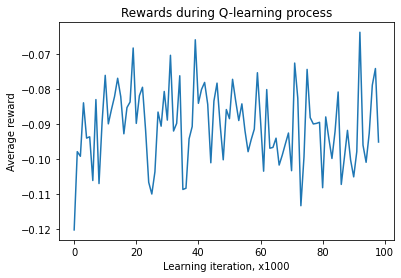

In [15]:
plt.title("Rewards during Q-learning process")
plt.plot(list(range(len(rewards))), rewards)
plt.ylabel("Average reward")
plt.xlabel("Learning iteration, x1000")
plt.show()

In [16]:
policy = policy_from_Q(Q)

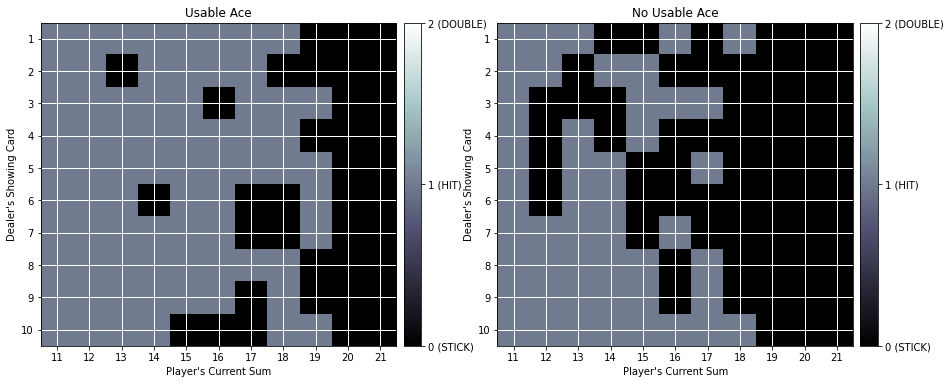

In [17]:
plot_policy(policy)

## Monte Carlo control

In [18]:
def update_Q(env, episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards) + 1)])
    
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha * (sum(rewards[i:] * discounts[:-(1+i)]) - old_Q)
    
    return Q

def montecarlo_control(env, num_episodes, alpha, gamma=1.0, eps_min=0.01, verbose=True, verbose_batch_size=5000):
    n_actions = env.action_space.n
    Q = defaultdict(lambda: np.zeros(n_actions))
    total_reward = 0.
    rewards = []
    
    for i in range(num_episodes):
        eps = max(1.0 / (i+1), eps_min)
        episode = generate_episode_from_Q(env, Q, eps, n_actions)
        Q = update_Q(env, episode, Q, alpha, gamma)
        cur_reward = episode[-1][-1]
        total_reward += cur_reward
        
        if i % verbose_batch_size == 0 and i > 0 and verbose:
            print(f"Episode {i} / {num_episodes}. Avg reward: {total_reward/verbose_batch_size}")
            total_reward = 0.
            rewards.append(estimate_reward(Q))
            
    return Q, rewards

In [19]:
%%time

for eps_min in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    tries = 5
    reward = 0
    
    for i in range(tries):
        Q, rewards = montecarlo_control(env, num_episodes=1000, alpha=0.01, eps_min=eps_min, verbose=False)
        reward += estimate_reward(Q)
        
    print(f'epsilon={eps_min}, reward={(reward / tries):.5f}')

epsilon=0.001, reward=-0.15756
epsilon=0.005, reward=-0.14115
epsilon=0.01, reward=-0.14720
epsilon=0.05, reward=-0.15388
epsilon=0.1, reward=-0.14432
epsilon=0.2, reward=-0.15152
CPU times: user 7min 37s, sys: 567 ms, total: 7min 37s
Wall time: 7min 37s


In [20]:
%%time
for alpha in [0.0001, 0.001, 0.01, 0.1, 0.2]:
    tries = 5
    reward = 0
    
    for i in range(tries):
        Q, rewards = montecarlo_control(env, num_episodes=1000, alpha=alpha, eps_min=0.01, verbose=False)
        reward += estimate_reward(Q)
        
    print(f'alpha={alpha}, reward={(reward / tries):.5f}')

alpha=0.0001, reward=-0.13885
alpha=0.001, reward=-0.13602
alpha=0.01, reward=-0.14210
alpha=0.1, reward=-0.15054
alpha=0.2, reward=-0.14151
CPU times: user 6min 21s, sys: 458 ms, total: 6min 21s
Wall time: 6min 21s


In [21]:
%%time
for gamma in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]:
    tries = 5
    reward = 0
    
    for i in range(tries):
        Q, rewards = montecarlo_control(env, num_episodes=1000, 
                                alpha=0.1, eps_min=0.01, gamma=gamma, verbose=False)
        reward += estimate_reward(Q)
        
    print(f'gamma={gamma}, reward={(reward / tries):.5f}')

gamma=0.5, reward=-0.13250
gamma=0.6, reward=-0.13789
gamma=0.7, reward=-0.15016
gamma=0.8, reward=-0.13507
gamma=0.9, reward=-0.14390
gamma=0.95, reward=-0.14882
gamma=1.0, reward=-0.15643
CPU times: user 9min 4s, sys: 688 ms, total: 9min 4s
Wall time: 9min 4s


In [22]:
%%time

Q, rewards = montecarlo_control(env, N_iterations, 
                                alpha=0.1, eps_min=0.01, gamma=0.8,
                                verbose_batch_size=N_verbose_batch_size)

Episode 1000 / 100000. Avg reward: -0.18
Episode 2000 / 100000. Avg reward: -0.123
Episode 3000 / 100000. Avg reward: -0.131
Episode 4000 / 100000. Avg reward: -0.105
Episode 5000 / 100000. Avg reward: -0.139
Episode 6000 / 100000. Avg reward: -0.078
Episode 7000 / 100000. Avg reward: -0.084
Episode 8000 / 100000. Avg reward: -0.1
Episode 9000 / 100000. Avg reward: -0.068
Episode 10000 / 100000. Avg reward: -0.112
Episode 11000 / 100000. Avg reward: -0.172
Episode 12000 / 100000. Avg reward: -0.144
Episode 13000 / 100000. Avg reward: -0.093
Episode 14000 / 100000. Avg reward: -0.101
Episode 15000 / 100000. Avg reward: -0.05
Episode 16000 / 100000. Avg reward: 0.001
Episode 17000 / 100000. Avg reward: -0.067
Episode 18000 / 100000. Avg reward: -0.072
Episode 19000 / 100000. Avg reward: -0.098
Episode 20000 / 100000. Avg reward: -0.022
Episode 21000 / 100000. Avg reward: -0.088
Episode 22000 / 100000. Avg reward: -0.059
Episode 23000 / 100000. Avg reward: -0.093
Episode 24000 / 100000. A

In [23]:
# estimated reward
estimate_reward(Q)

-0.05551

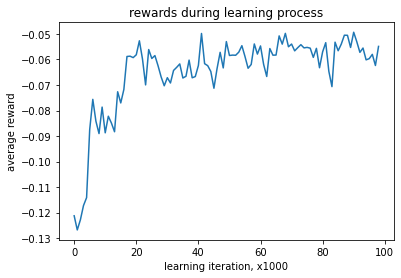

In [24]:
plt.plot(list(range(len(rewards))), rewards)
plt.title("rewards during learning process")
plt.ylabel("average reward")
plt.xlabel("learning iteration, x1000")
plt.show()

In [25]:
policy = policy_from_Q(Q)

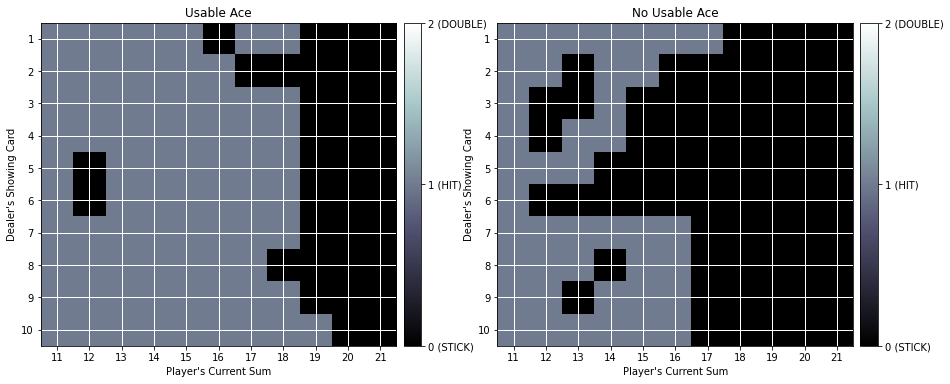

In [26]:
plot_policy(policy)

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли
получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила
были упрощёнными, а на самом деле у игрока есть ещё и другие возможности.
Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением
ставки. Итак, у игрока появляется дополнительное действие:
* double — удвоить ставку; при этом больше действий делать нельзя, игроку
выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш
удваивается.

4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI
Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта,
постройте графики, аналогичные п.2.

In [28]:
from blackjack_double import BlackjackEnvDouble

env = BlackjackEnvDouble(natural=True)

In [29]:
env.reset()

# check that new action 'double' is available
env.step(2)

((12, 10, False), -2.0, True, False, {})

In [30]:
%%time

for eps_min in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    tries = 5
    reward = 0
    
    for i in range(tries):
        Q, rewards = montecarlo_control(env, num_episodes=1000, alpha=0.01, eps_min=eps_min, verbose=False)
        reward += estimate_reward(Q)
        
    print(f'epsilon={eps_min}, reward={(reward / tries):.5f}')

epsilon=0.001, reward=-0.21927
epsilon=0.005, reward=-0.19345
epsilon=0.01, reward=-0.23956
epsilon=0.05, reward=-0.22511
epsilon=0.1, reward=-0.21255
epsilon=0.2, reward=-0.22328
CPU times: user 6min 4s, sys: 423 ms, total: 6min 4s
Wall time: 6min 4s


In [31]:
%%time
for alpha in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    tries = 5
    reward = 0
    
    for i in range(tries):
        Q, rewards = montecarlo_control(env, num_episodes=1000, alpha=alpha, eps_min=0.1, verbose=False)
        reward += estimate_reward(Q)
        
    print(f'alpha={alpha}, reward={(reward / tries):.5f}')

alpha=0.0001, reward=-0.21334
alpha=0.001, reward=-0.24168
alpha=0.01, reward=-0.20544
alpha=0.1, reward=-0.22031
alpha=0.2, reward=-0.23946
alpha=0.3, reward=-0.20341
alpha=0.4, reward=-0.19888
alpha=0.5, reward=-0.22823
alpha=0.6, reward=-0.20052
alpha=0.7, reward=-0.22011
alpha=0.8, reward=-0.21293
alpha=0.9, reward=-0.20870
alpha=0.95, reward=-0.20882
CPU times: user 13min 7s, sys: 905 ms, total: 13min 8s
Wall time: 13min 8s


In [32]:
%%time
for gamma in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]:
    tries = 5
    reward = 0
    
    for i in range(tries):
        Q, rewards = montecarlo_control(env, num_episodes=1000, 
                                alpha=0.2, eps_min=0.1, gamma=gamma, verbose=False)
        reward += estimate_reward(Q)
        
    print(f'gamma={gamma}, reward={(reward / tries):.5f}')

gamma=0.5, reward=-0.18257
gamma=0.6, reward=-0.20146
gamma=0.7, reward=-0.20154
gamma=0.8, reward=-0.20597
gamma=0.9, reward=-0.22093
gamma=0.95, reward=-0.20628
gamma=1.0, reward=-0.20435
CPU times: user 7min 12s, sys: 510 ms, total: 7min 12s
Wall time: 7min 12s


In [33]:
%%time

Q, rewards = montecarlo_control(env, N_iterations, 
                                alpha=0.1, eps_min=0.01, gamma=0.8, 
                                verbose_batch_size=N_verbose_batch_size)

Episode 1000 / 100000. Avg reward: -0.241
Episode 2000 / 100000. Avg reward: -0.195
Episode 3000 / 100000. Avg reward: -0.116
Episode 4000 / 100000. Avg reward: -0.162
Episode 5000 / 100000. Avg reward: -0.162
Episode 6000 / 100000. Avg reward: -0.074
Episode 7000 / 100000. Avg reward: -0.069
Episode 8000 / 100000. Avg reward: -0.13
Episode 9000 / 100000. Avg reward: -0.176
Episode 10000 / 100000. Avg reward: -0.145
Episode 11000 / 100000. Avg reward: -0.073
Episode 12000 / 100000. Avg reward: -0.154
Episode 13000 / 100000. Avg reward: -0.087
Episode 14000 / 100000. Avg reward: -0.119
Episode 15000 / 100000. Avg reward: -0.106
Episode 16000 / 100000. Avg reward: -0.11
Episode 17000 / 100000. Avg reward: -0.048
Episode 18000 / 100000. Avg reward: -0.159
Episode 19000 / 100000. Avg reward: -0.112
Episode 20000 / 100000. Avg reward: -0.092
Episode 21000 / 100000. Avg reward: -0.084
Episode 22000 / 100000. Avg reward: -0.056
Episode 23000 / 100000. Avg reward: -0.051
Episode 24000 / 100000

In [34]:
# estimated reward
estimate_reward(Q)

-0.06394

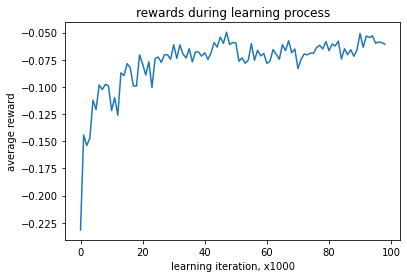

In [35]:
plt.plot(list(range(len(rewards))), rewards)
plt.title("rewards during learning process")
plt.ylabel("average reward")
plt.xlabel("learning iteration, x1000")
plt.show()

In [36]:
policy = policy_from_Q(Q)

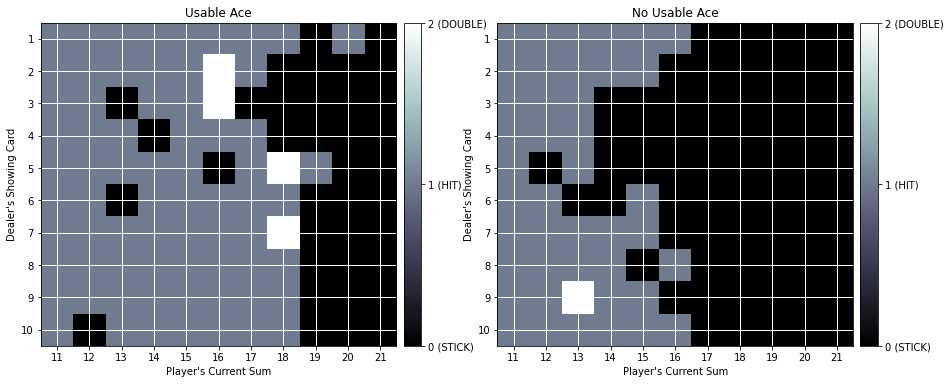

In [37]:
plot_policy(policy)

## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в
том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это
слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха
колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет
информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно
удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут
раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог
считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами,
так что подсчёт можно считать автоматическим.

6. Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в
котором игрок имеет возможность “считать карты” в колоде. Это можно сделать
разными способами; возможно, вам поможет статья википедии о блекджеке (а
возможно, и нет).
7. Реализуйте метод обучения с подкреплением без модели для этого варианта,
постройте графики, аналогичные п.2.

In [4]:
from blackjack_count import BlackjackEnvCount

env = BlackjackEnvCount(natural=True)

In [5]:
# validate that card countring works
assert len(env.deck) == 52
env.reset()
assert len(env.deck) == 48
env.step(1)
assert len(env.deck) == 47
env.reset()
assert len(env.deck) == 43

for _ in range(14, 43):
    env.step(1)
    
assert len(env.deck) == 14
env.reset()

# deck shuffled and reseted
assert len(env.deck) > 40
len(env.deck)

48

In [6]:
# counting cards with the simplest schema

# 2,3,4,5,6 - +1
# 7,8,9 - +0
# 10, 11 - -1

cards_counter = 0

def count_card(card):
    global cards_counter
    if card < 7:
        cards_counter += 1
    if card >= 10:
        cards_counter -= 1

def count_cards(cards):
    for card in cards:
        count_card(card)

In [10]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    global cards_counter
    episode = []
    state, is_deck_shuffled = env.reset()
    
    if is_deck_shuffled:
        cards_counter = 0
        
    # we can see only one dealer's card, but both our cards
    count_cards((env.dealer[0], env.player[0], env.player[1]))
    
    while True:
        state = (*state, cards_counter)
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
            if state in Q else env.action_space.sample()
        next_state, reward, done, _, _ = env.step(action)
        count_card(env.player[-1])
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            break
            
    # now we can see all dealer's cards
    count_cards(env.dealer[1:])
    return episode


def montecarlo_control(env, num_episodes, alpha, gamma=1.0, eps_min=0.01, verbose=True, verbose_batch_size=5000):
    n_actions = env.action_space.n
    Q = defaultdict(lambda: np.zeros(n_actions))
    total_reward = 0.
    rewards = []
    
    for i in range(num_episodes):
        eps = max(1.0 / (i+1), eps_min)
        episode = generate_episode_from_Q(env, Q, eps, n_actions)
        Q = update_Q(env, episode, Q, alpha, gamma)
        cur_reward = episode[-1][-1]
        total_reward += cur_reward
        
        if i % verbose_batch_size == 0 and i > 0 and verbose:
            print(f"Episode {i} / {num_episodes}. Avg reward: {total_reward/verbose_batch_size}")
            total_reward = 0.
            rewards.append(estimate_reward(Q))
            
    return Q, rewards

In [11]:
%%time

N_verbose_batch_size = 50000
N_iterations = N_verbose_batch_size * 200

Q, rewards = montecarlo_control(env, N_iterations, 
                                alpha=0.1, gamma=1, eps_min=0.001,
                                verbose_batch_size=N_verbose_batch_size)

Episode 50000 / 10000000. Avg reward: -0.18242
Episode 100000 / 10000000. Avg reward: -0.12163
Episode 150000 / 10000000. Avg reward: -0.09967
Episode 200000 / 10000000. Avg reward: -0.0826
Episode 250000 / 10000000. Avg reward: -0.07732
Episode 300000 / 10000000. Avg reward: -0.0746
Episode 350000 / 10000000. Avg reward: -0.069
Episode 400000 / 10000000. Avg reward: -0.05633
Episode 450000 / 10000000. Avg reward: -0.06511
Episode 500000 / 10000000. Avg reward: -0.05844
Episode 550000 / 10000000. Avg reward: -0.05991
Episode 600000 / 10000000. Avg reward: -0.05344
Episode 650000 / 10000000. Avg reward: -0.04527
Episode 700000 / 10000000. Avg reward: -0.05208
Episode 750000 / 10000000. Avg reward: -0.04449
Episode 800000 / 10000000. Avg reward: -0.06154
Episode 850000 / 10000000. Avg reward: -0.04685
Episode 900000 / 10000000. Avg reward: -0.05638
Episode 950000 / 10000000. Avg reward: -0.0551
Episode 1000000 / 10000000. Avg reward: -0.04822
Episode 1050000 / 10000000. Avg reward: -0.03

Episode 8500000 / 10000000. Avg reward: -0.03429
Episode 8550000 / 10000000. Avg reward: -0.03552
Episode 8600000 / 10000000. Avg reward: -0.0335
Episode 8650000 / 10000000. Avg reward: -0.03096
Episode 8700000 / 10000000. Avg reward: -0.03909
Episode 8750000 / 10000000. Avg reward: -0.03311
Episode 8800000 / 10000000. Avg reward: -0.02655
Episode 8850000 / 10000000. Avg reward: -0.03696
Episode 8900000 / 10000000. Avg reward: -0.03676
Episode 8950000 / 10000000. Avg reward: -0.03668
Episode 9000000 / 10000000. Avg reward: -0.03841
Episode 9050000 / 10000000. Avg reward: -0.0367
Episode 9100000 / 10000000. Avg reward: -0.03527
Episode 9150000 / 10000000. Avg reward: -0.03946
Episode 9200000 / 10000000. Avg reward: -0.03891
Episode 9250000 / 10000000. Avg reward: -0.03495
Episode 9300000 / 10000000. Avg reward: -0.0413
Episode 9350000 / 10000000. Avg reward: -0.03747
Episode 9400000 / 10000000. Avg reward: -0.03502
Episode 9450000 / 10000000. Avg reward: -0.02883
Episode 9500000 / 10000

In [12]:
# estimated reward
estimate_reward(Q, 1000000)

-0.0310635

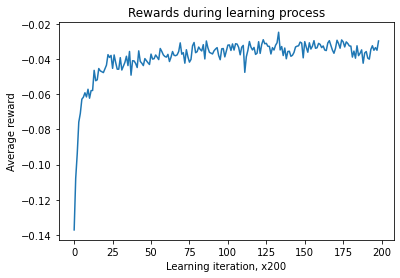

In [14]:
plt.plot(list(range(len(rewards))), rewards)
plt.title("Rewards during learning process")
plt.ylabel("Average reward")
plt.xlabel("Learning iteration, x200")
plt.show()

In [15]:
policy = policy_from_Q(Q)

In [16]:
def plot_policy(policy, card_count):

    def get_Z(x, y, usable_ace, card_count):
        if (x,y,usable_ace, card_count) in policy:
            
            return policy[(x,y,usable_ace, card_count)]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace, card_count) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('bone'), vmin=0, vmax=2, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1,2], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)', '2 (DOUBLE)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

card count: -10


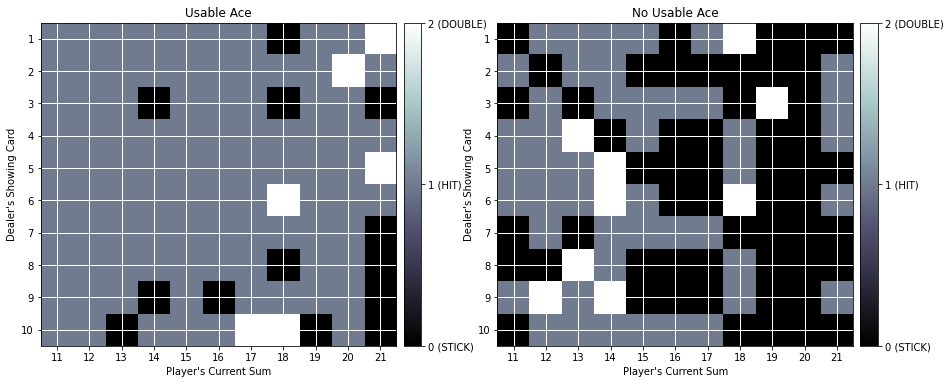

card count: -7


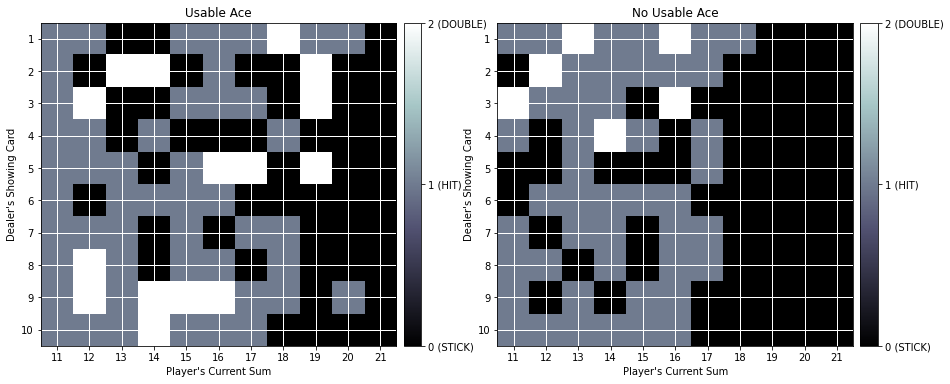

card count: -4


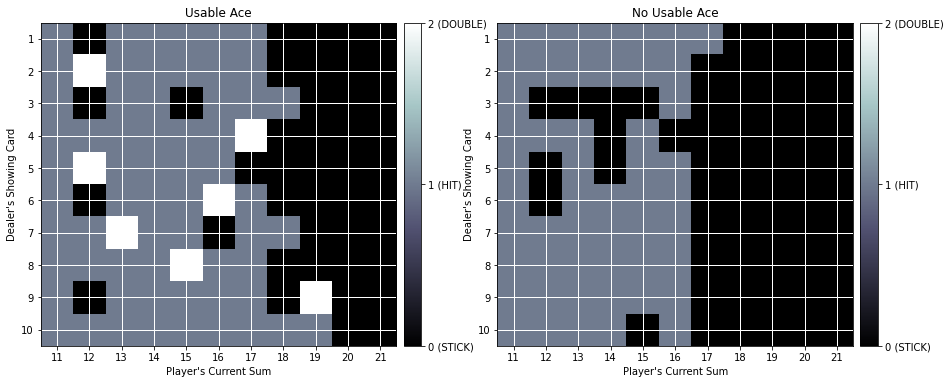

card count: -1


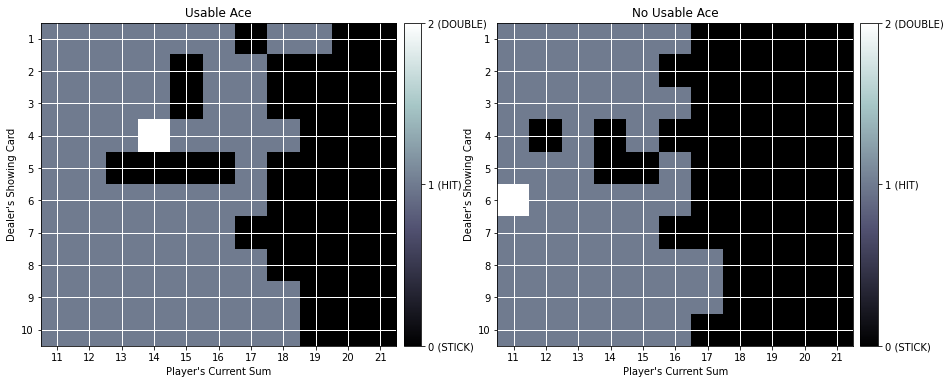

card count: 2


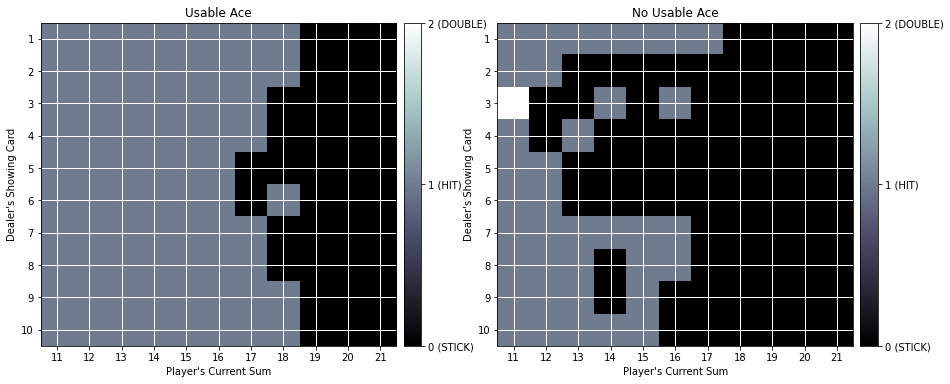

card count: 5


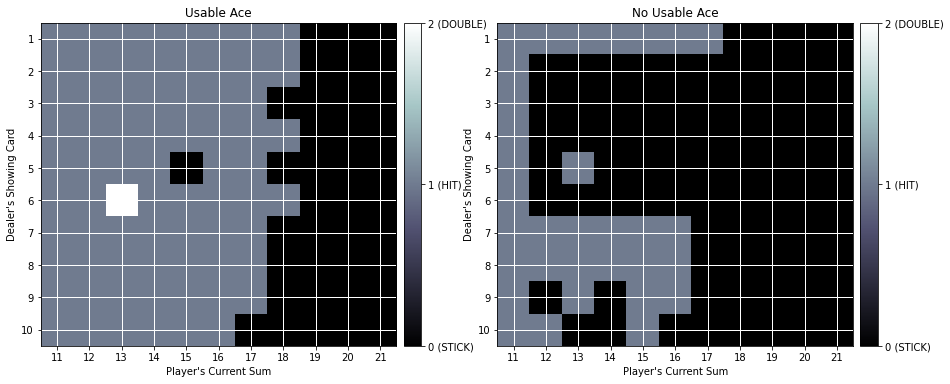

card count: 8


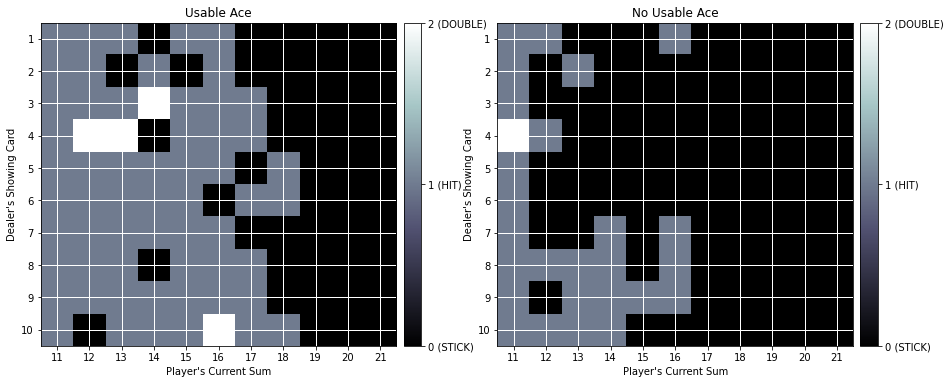

In [17]:
for card_count in range(-10, 10, 3):
    print(f"card count: {card_count}")
    plot_policy(policy, card_count)

With simple strategy "19, 20, 21" the reward is -0.198529

On basic Blackjack environment Q-learning reached -0.109 and Monte Carlo control gave -0.05551. Because of these scores I decided that MC control is more promising and evaluated later environments with this algorithm. 

After adding "double" to the environment my calculations with MC control showed -0.06394, I think it just didn't converge compeletely or some other hyperparameters are optimal.

Blackjack with counts and double reached average reward of -0.0310635. It still loses money!